# Association Rule Mining on Philippine Earthquake Clusters


## Import Libraries

In [152]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.preprocessing import TransactionEncoder

## Initial Data Exploration

In [153]:
df = pd.read_csv("../dataset/phivolcs_earthquake_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118955 entries, 0 to 118954
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Date_Time_PH       118955 non-null  object 
 1   Latitude           118931 non-null  float64
 2   Longitude          118931 non-null  float64
 3   Depth_In_Km        118954 non-null  object 
 4   Magnitude          118955 non-null  float64
 5   Location           118955 non-null  object 
 6   Specific_Location  118955 non-null  object 
 7   General_Location   118955 non-null  object 
dtypes: float64(3), object(5)
memory usage: 7.3+ MB


In [154]:
df.describe()

,Latitude,Longitude,Magnitude
count,118931.000000,118931.000000,118955.000000
mean,10.903026,124.056514,2.509793
std,3.977757,2.544317,0.701736
min,1.730000,10.560000,1.000000
25%,7.920000,121.420000,2.000000
50%,9.970000,124.870000,2.400000
75%,13.750000,126.270000,2.900000
max,24.840000,163.630000,7.500000


In [155]:
df.head()

,Date_Time_PH,Latitude,Longitude,Depth_In_Km,Magnitude,Location,Specific_Location,General_Location
0,2025-12-13 10:42:00,7.62,127.04,15.0,3.1,054 km N 85° E of Baganga (Davao Oriental),Baganga,Davao Oriental
1,2025-12-13 10:16:00,12.86,123.53,5.0,2.1,009 km S 56° W of Donsol (Sorsogon),Donsol,Sorsogon
2,2025-12-13 10:01:00,7.54,126.74,28.0,4.5,020 km S 79° E of Baganga (Davao Oriental),Baganga,Davao Oriental
3,2025-12-13 09:55:00,10.98,123.89,33.0,2.1,012 km S 52° W of City Of Bogo (Cebu),City Of Bogo,Cebu
4,2025-12-13 08:38:00,14.14,120.02,127.0,1.7,033 km N 20° W of Lubang (Occidental Mindoro),Lubang,Occidental Mindoro


### Checking for duplicates

In [159]:
# Count total duplicate rows
count_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {count_duplicates}")


Number of duplicate rows: 0


### 1. Dropping rows with missing values

In [160]:
df.isnull().sum()

Date_Time_PH         0
Latitude             0
Longitude            0
Depth_In_Km          0
Magnitude            0
Location             0
Specific_Location    0
General_Location     0
dtype: int64

In [161]:
df = df.dropna()

In [162]:
df.isnull().sum()

Date_Time_PH         0
Latitude             0
Longitude            0
Depth_In_Km          0
Magnitude            0
Location             0
Specific_Location    0
General_Location     0
dtype: int64

### 2. Limiting data from 2019 to 2025

In [163]:
df['Date_Time_PH'] = pd.to_datetime(df['Date_Time_PH'])

'''
    Filtering dataset from 2019 to 2025
'''
start_date = '2019-01-01'
end_date = '2025-12-31' 
df = df[(df['Date_Time_PH'] >= start_date) & (df['Date_Time_PH'] <= end_date)]

print(f"Dataset filtered (2019-2025). New row count: {len(df)}")

Dataset filtered (2019-2025). New row count: 110350


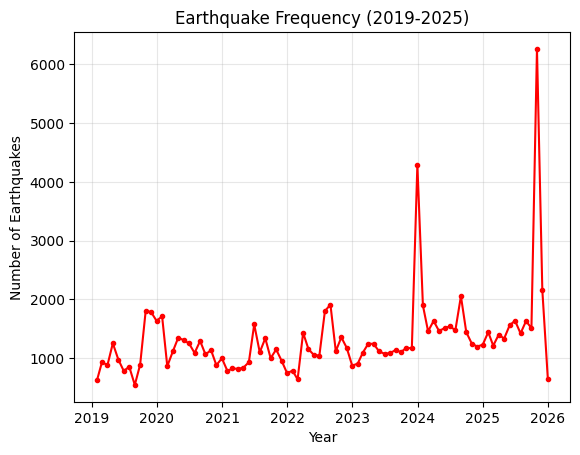

In [164]:
# Resample data by Month ('M') to see the volume over time
monthly_counts = df.set_index('Date_Time_PH').resample('ME').size()
plt.plot(monthly_counts.index, monthly_counts.values, color='red', marker='o', markersize=3)
plt.title('Earthquake Frequency (2019-2025)')
plt.ylabel('Number of Earthquakes')
plt.xlabel('Year')
plt.grid(True, alpha=0.3)

### 3. Turn the date in Philippine time to Time in Day

In [165]:
# Date_Time_PH -> Time of Day
df['Date_Time_PH'] = pd.to_datetime(df['Date_Time_PH'])
df['Hour'] = df['Date_Time_PH'].dt.hour

def get_time_of_day(h):
    if 0 <= h < 6: return 'Time_Night'
    elif 6 <= h < 12: return 'Time_Morning'
    elif 12 <= h < 18: return 'Time_Afternoon'
    else: return 'Time_Evening'

df['Time_Bin'] = df['Hour'].apply(get_time_of_day)

### 4. Binning magnitude to categories (e.g., micro, minor, light, etc.)

In [166]:
'''
    Binning numerical data to categorical data
'''
# Magnitude -> Category
bins_mag = [0, 3, 4, 5, 6, 7, 10]
labels_mag = ['Magnitude_Micro', 'Magnitude_Minor', 'Magnitude_Light', 'Magnitude_Moderate', 'Magnitude_Strong', 'Magnitude_Major']
df['Magnitude_Bin'] = pd.cut(df['Magnitude'], bins=bins_mag, labels=labels_mag)


### 5. Binning depth to categories

In [167]:
'''
    Binning numerical data to categorical data. Convert Depth_In_Km first from object to int.
'''
# 1. Coerce errors to NaN
df["Depth_In_Km"] = pd.to_numeric(df["Depth_In_Km"], errors='coerce')

# 2. Drop rows where Depth is NaN
df = df.dropna(subset=["Depth_In_Km"])

# 3. Convert to integer
df["Depth_In_Km"] = df["Depth_In_Km"].astype('int64')

bins_depth = [0, 70, 300, 1000]
labels_depth = ['Depth_Shallow', 'Depth_Intermediate', 'Depth_Deep']
df['Depth_Bin'] = pd.cut(df['Depth_In_Km'], bins=bins_depth, labels=labels_depth)

### 6. Handling location bin

In [168]:
# D. Location (Using General_Location)
# We make it uppercase and remove whitespace to avoid "Davao " vs "Davao" mismatch
df['Location_Bin'] = df['General_Location'].str.upper().str.strip()

### 7. Create final basket for Apriori

In [169]:
# --- FINAL BASKET CREATION ---
# Create the transaction dataset with just the categorical columns
transactions = df[['Location_Bin', 'Time_Bin', 'Magnitude_Bin', 'Depth_Bin']].astype(str)

print("\nSample Transaction Data for Apriori:")
print(transactions.head())


Sample Transaction Data for Apriori:
         Location_Bin      Time_Bin    Magnitude_Bin           Depth_Bin
0      DAVAO ORIENTAL  Time_Morning  Magnitude_Minor       Depth_Shallow
1            SORSOGON  Time_Morning  Magnitude_Micro       Depth_Shallow
2      DAVAO ORIENTAL  Time_Morning  Magnitude_Light       Depth_Shallow
3                CEBU  Time_Morning  Magnitude_Micro       Depth_Shallow
4  OCCIDENTAL MINDORO  Time_Morning  Magnitude_Micro  Depth_Intermediate


In [170]:
transactions.head()

,Location_Bin,Time_Bin,Magnitude_Bin,Depth_Bin
0,DAVAO ORIENTAL,Time_Morning,Magnitude_Minor,Depth_Shallow
1,SORSOGON,Time_Morning,Magnitude_Micro,Depth_Shallow
2,DAVAO ORIENTAL,Time_Morning,Magnitude_Light,Depth_Shallow
3,CEBU,Time_Morning,Magnitude_Micro,Depth_Shallow
4,OCCIDENTAL MINDORO,Time_Morning,Magnitude_Micro,Depth_Intermediate


In [171]:
transactions.to_csv('binned_data.csv')

## Exploratory Data Analysis and Data Visualization (Binned Dataset)

In [172]:
earthquake_df = pd.read_csv("../dataset/binned_data.csv")

### 1. What are are top 20 most earthquake active locations in the Philippines?

From 2019 to 2025, we can see here that the province of Surigao del Sur is the province that experienced the most earthquakes, followed by Davao Oriental, then Surigao del Norte.

Text(0.5, 0, 'Count')

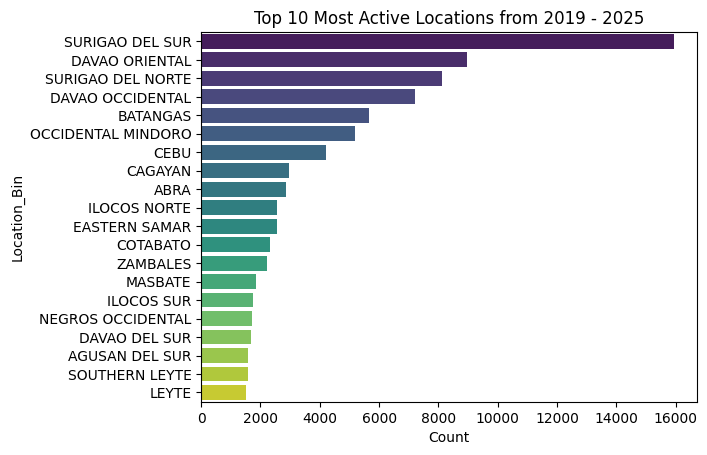

In [173]:
# Check the Top 10 Locations
top_locs = earthquake_df['Location_Bin'].value_counts().head(20)
sns.barplot(x=top_locs.values, y=top_locs.index, hue=top_locs.index, palette='viridis')
plt.title('Top 10 Most Active Locations from 2019 - 2025')
plt.xlabel('Count')

## 

### 2. Which combination of Depth and Magnitude types appear most frequently together?

Text(50.58159722222221, 0.5, 'Depth Class')

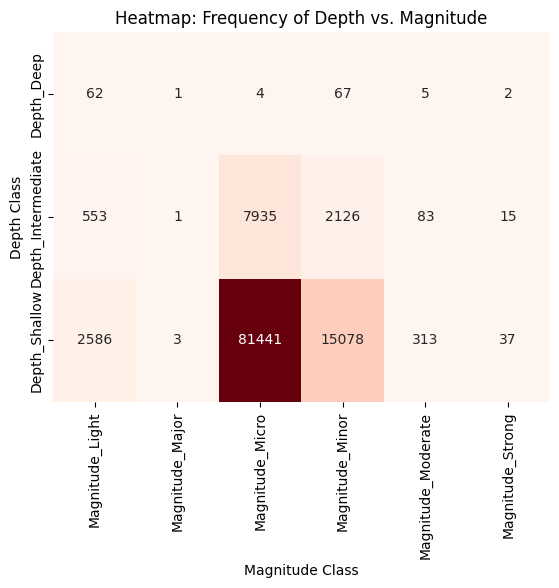

In [174]:
# Create a cross-tabulation (Count of overlaps)
ct_depth_mag = pd.crosstab(earthquake_df['Depth_Bin'], earthquake_df['Magnitude_Bin'])
# Plot Heatmap
sns.heatmap(ct_depth_mag, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.title('Heatmap: Frequency of Depth vs. Magnitude')
plt.xlabel('Magnitude Class')
plt.ylabel('Depth Class')

## 3. Did we slice the data correctly?
### Suggestion: Apply new bins

We can see that fron the data binning earlier, one bin shows to dominate other bins in the Depth category, and that is the Depth_Shallow.

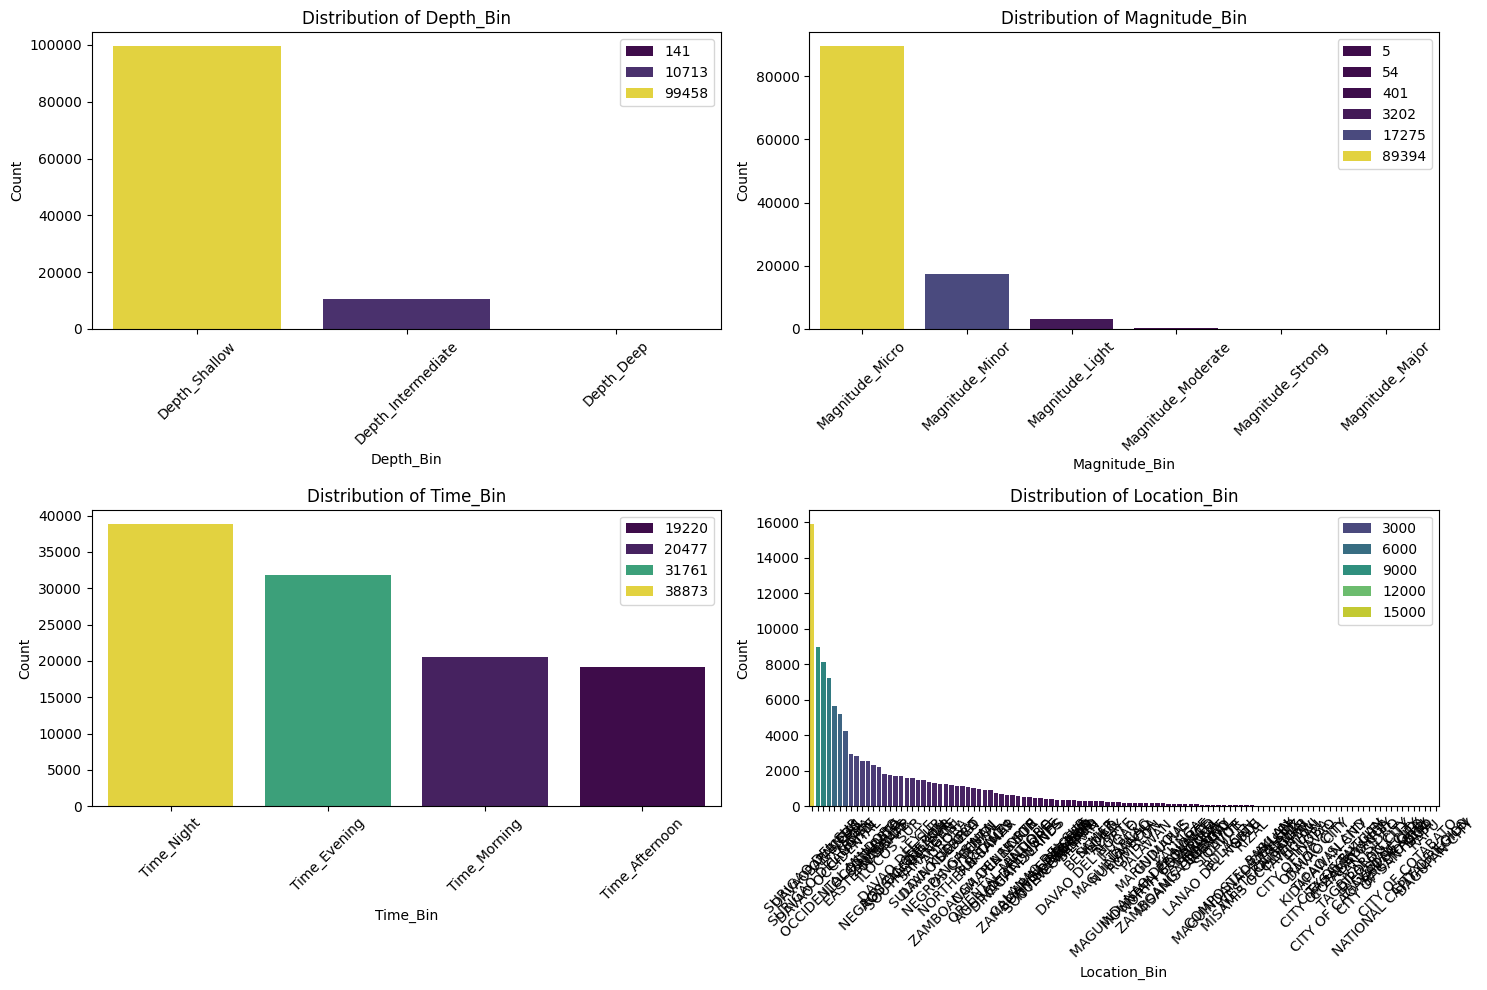

Depth Distribution (%):
Depth_Bin
Depth_Shallow         90.160635
Depth_Intermediate     9.711545
Depth_Deep             0.127819
Name: proportion, dtype: float64


In [175]:
'''
    We check the distribution of each bin to see which ones are dominant among others. This is to prevent boring/predictable association rules (everything will fall into one category).
'''

binned_cols = ['Depth_Bin', 'Magnitude_Bin', 'Time_Bin', 'Location_Bin']

# Create a figure with subplots
plt.figure(figsize=(15, 10))

for i, col in enumerate(binned_cols):
    plt.subplot(2, 2, i+1) # Create a grid of charts
    
    # Calculate counts
    counts = df[col].value_counts()
    
    # Plot bar chart
    sns.barplot(x=counts.index, y=counts.values, hue=counts.values, palette='viridis')
    plt.title(f'Distribution of {col}')
    plt.ylabel('Count')
    plt.xticks(rotation=45) # Rotate labels so they don't overlap

plt.tight_layout()
plt.show()

# Print exact percentages for precision
print("Depth Distribution (%):")
print(df['Depth_Bin'].value_counts(normalize=True) * 100  )


### Updating Depth Binning and Location Binning

In [194]:
'''
    Update depth binning
'''
bins_depth_new = [0, 15, 40, 120, 1000]
labels_depth_new = ['Depth_Surface', 'Depth_Crust', 'Depth_Interface', 'Depth_Deep']
earthquake_df['Depth_Bin'] = pd.cut(df['Depth_In_Km'], bins=bins_depth_new, labels=labels_depth_new, right=False)


'''
    Keep seismically active regions/provinces in the Philippines to avoid expanding dataset to 100+ columns and
      potentially producing bad association rules. We get the top 20 seismically active provinces in the Philippines.
'''

top_locations = earthquake_df['Location_Bin'].value_counts().head(20).index
print(top_locations)
# Replace everything else with 'OTHER'
earthquake_df['Location_Optimized'] = earthquake_df['Location_Bin'].apply(lambda x: x if x in top_locations else 'LOC_OTHER')

print(f"Original Unique Locations: {df['Location_Bin'].nunique()}")
print(f"Optimized Unique Locations: {earthquake_df['Location_Optimized'].nunique()}") 

Index(['SURIGAO DEL SUR', 'DAVAO ORIENTAL', 'SURIGAO DEL NORTE',
       'DAVAO OCCIDENTAL', 'BATANGAS', 'OCCIDENTAL MINDORO', 'CEBU', 'CAGAYAN',
       'ABRA', 'ILOCOS NORTE', 'EASTERN SAMAR', 'COTABATO', 'ZAMBALES',
       'MASBATE', 'ILOCOS SUR', 'NEGROS OCCIDENTAL', 'DAVAO DEL SUR',
       'AGUSAN DEL SUR', 'SOUTHERN LEYTE', 'LEYTE'],
      dtype='object', name='Location_Bin')
Original Unique Locations: 113
Optimized Unique Locations: 21


In [195]:
earthquake_df.head(5)

,Unnamed: 0,Location_Bin,Time_Bin,Magnitude_Bin,Depth_Bin,Location_Optimized
0,0,DAVAO ORIENTAL,Time_Morning,Magnitude_Minor,Depth_Crust,DAVAO ORIENTAL
1,1,SORSOGON,Time_Morning,Magnitude_Micro,Depth_Surface,LOC_OTHER
2,2,DAVAO ORIENTAL,Time_Morning,Magnitude_Light,Depth_Crust,DAVAO ORIENTAL
3,3,CEBU,Time_Morning,Magnitude_Micro,Depth_Crust,CEBU
4,4,OCCIDENTAL MINDORO,Time_Morning,Magnitude_Micro,Depth_Deep,OCCIDENTAL MINDORO


## Finalizing Columns

In [196]:
basket_df = earthquake_df[['Time_Bin', 'Depth_Bin', 'Magnitude_Bin', 'Location_Optimized']].astype(str)

print("Final Transaction Data:")
print(basket_df.head())

Final Transaction Data:
       Time_Bin      Depth_Bin    Magnitude_Bin  Location_Optimized
0  Time_Morning    Depth_Crust  Magnitude_Minor      DAVAO ORIENTAL
1  Time_Morning  Depth_Surface  Magnitude_Micro           LOC_OTHER
2  Time_Morning    Depth_Crust  Magnitude_Light      DAVAO ORIENTAL
3  Time_Morning    Depth_Crust  Magnitude_Micro                CEBU
4  Time_Morning     Depth_Deep  Magnitude_Micro  OCCIDENTAL MINDORO


In [198]:
basket_df.to_csv("../dataset/basket_data.csv")

## One-Hot Encoding Categorical Features

In [201]:
from mlxtend.preprocessing import TransactionEncoder

# Convert to List of Lists
transactions = basket_df.values.tolist()

# Instantiate and fit the encoder
encoder = TransactionEncoder()
onehot_matrix = encoder.fit(transactions).transform(transactions)

# Convert back to DataFrame (The "Apriori Ready" format)
df_encoded = pd.DataFrame(onehot_matrix, columns=encoder.columns_)

# Check the shape: (Number of Earthquakes, Number of Unique Items)
print(f"Matrix Shape: {df_encoded.shape}")
print(df_encoded.head())

Matrix Shape: (110331, 36)
    ABRA  AGUSAN DEL SUR  BATANGAS  CAGAYAN   CEBU  COTABATO  DAVAO DEL SUR  \
0  False           False     False    False  False     False          False   
1  False           False     False    False  False     False          False   
2  False           False     False    False  False     False          False   
3  False           False     False    False   True     False          False   
4  False           False     False    False  False     False          False   

   DAVAO OCCIDENTAL  DAVAO ORIENTAL  Depth_Crust  ...  OCCIDENTAL MINDORO  \
0             False            True         True  ...               False   
1             False           False        False  ...               False   
2             False            True         True  ...               False   
3             False           False         True  ...               False   
4             False           False        False  ...                True   

   SOUTHERN LEYTE  SURIGAO DEL NORT

## Implementing Apriori and Generating Rules

In [206]:
from mlxtend.frequent_patterns import apriori, association_rules

# Mine Frequent Itemsets
# min_support=0.01 means the pattern must appear in at least 1% of the data
# If you get NO results, lower this to 0.005 or 0.001
frequent_itemsets = apriori(df_encoded, min_support=0.01, use_colnames=True)

# Generate Rules
# metric="lift" > 1.0 ensures we only get positive correlations
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.1)

# Sort by Lift (Strength of Association)
rules = rules.sort_values('lift', ascending=False)

# Display the Top 10 Rules
print("\nAssociation Rules:\n", rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(20))


Association Rules:
                          antecedents                       consequents  \
46    (Depth_Crust, Magnitude_Minor)                (DAVAO OCCIDENTAL)   
49                (DAVAO OCCIDENTAL)    (Depth_Crust, Magnitude_Minor)   
17                 (Magnitude_Minor)                (DAVAO OCCIDENTAL)   
16                (DAVAO OCCIDENTAL)                 (Magnitude_Minor)   
48                 (Magnitude_Minor)   (Depth_Crust, DAVAO OCCIDENTAL)   
47   (Depth_Crust, DAVAO OCCIDENTAL)                 (Magnitude_Minor)   
37  (Magnitude_Micro, Depth_Surface)                            (CEBU)   
38                            (CEBU)  (Magnitude_Micro, Depth_Surface)   
19                 (Magnitude_Minor)                  (DAVAO ORIENTAL)   
18                  (DAVAO ORIENTAL)                 (Magnitude_Minor)   
11                   (Depth_Surface)                            (CEBU)   
10                            (CEBU)                   (Depth_Surface)   
36           (Mag

## Sorting by lifts (strongest association first)

In [207]:
all_rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

all_rules = all_rules.sort_values('lift', ascending=False)

# Convert frozensets to strings so they are readable in CSV
all_rules['antecedents'] = all_rules['antecedents'].apply(lambda x: ', '.join(list(x)))
all_rules['consequents'] = all_rules['consequents'].apply(lambda x: ', '.join(list(x)))

# 5. Export to CSV (This is your "Fair" dataset)
final_cols = ['antecedents', 'consequents', 'support', 'confidence', 'lift']

# Create the clean dataframe
clean_rules = all_rules[final_cols]
clean_rules.to_csv("clean2_association_rules.csv", index=False)
print(f"Successfully generated {len(clean_rules)} rules. Saved to 'clean2_association_rules.csv'.")

# 6. Display Stats
print(f"\nHighest Lift: {all_rules['lift'].max()}")
print(f"Lowest Lift: {all_rules['lift'].min()}")

Successfully generated 556 rules. Saved to 'clean2_association_rules.csv'.

Highest Lift: 2.6617111000986764
Lowest Lift: 1.0001423869755905


## Visualizing generated rules

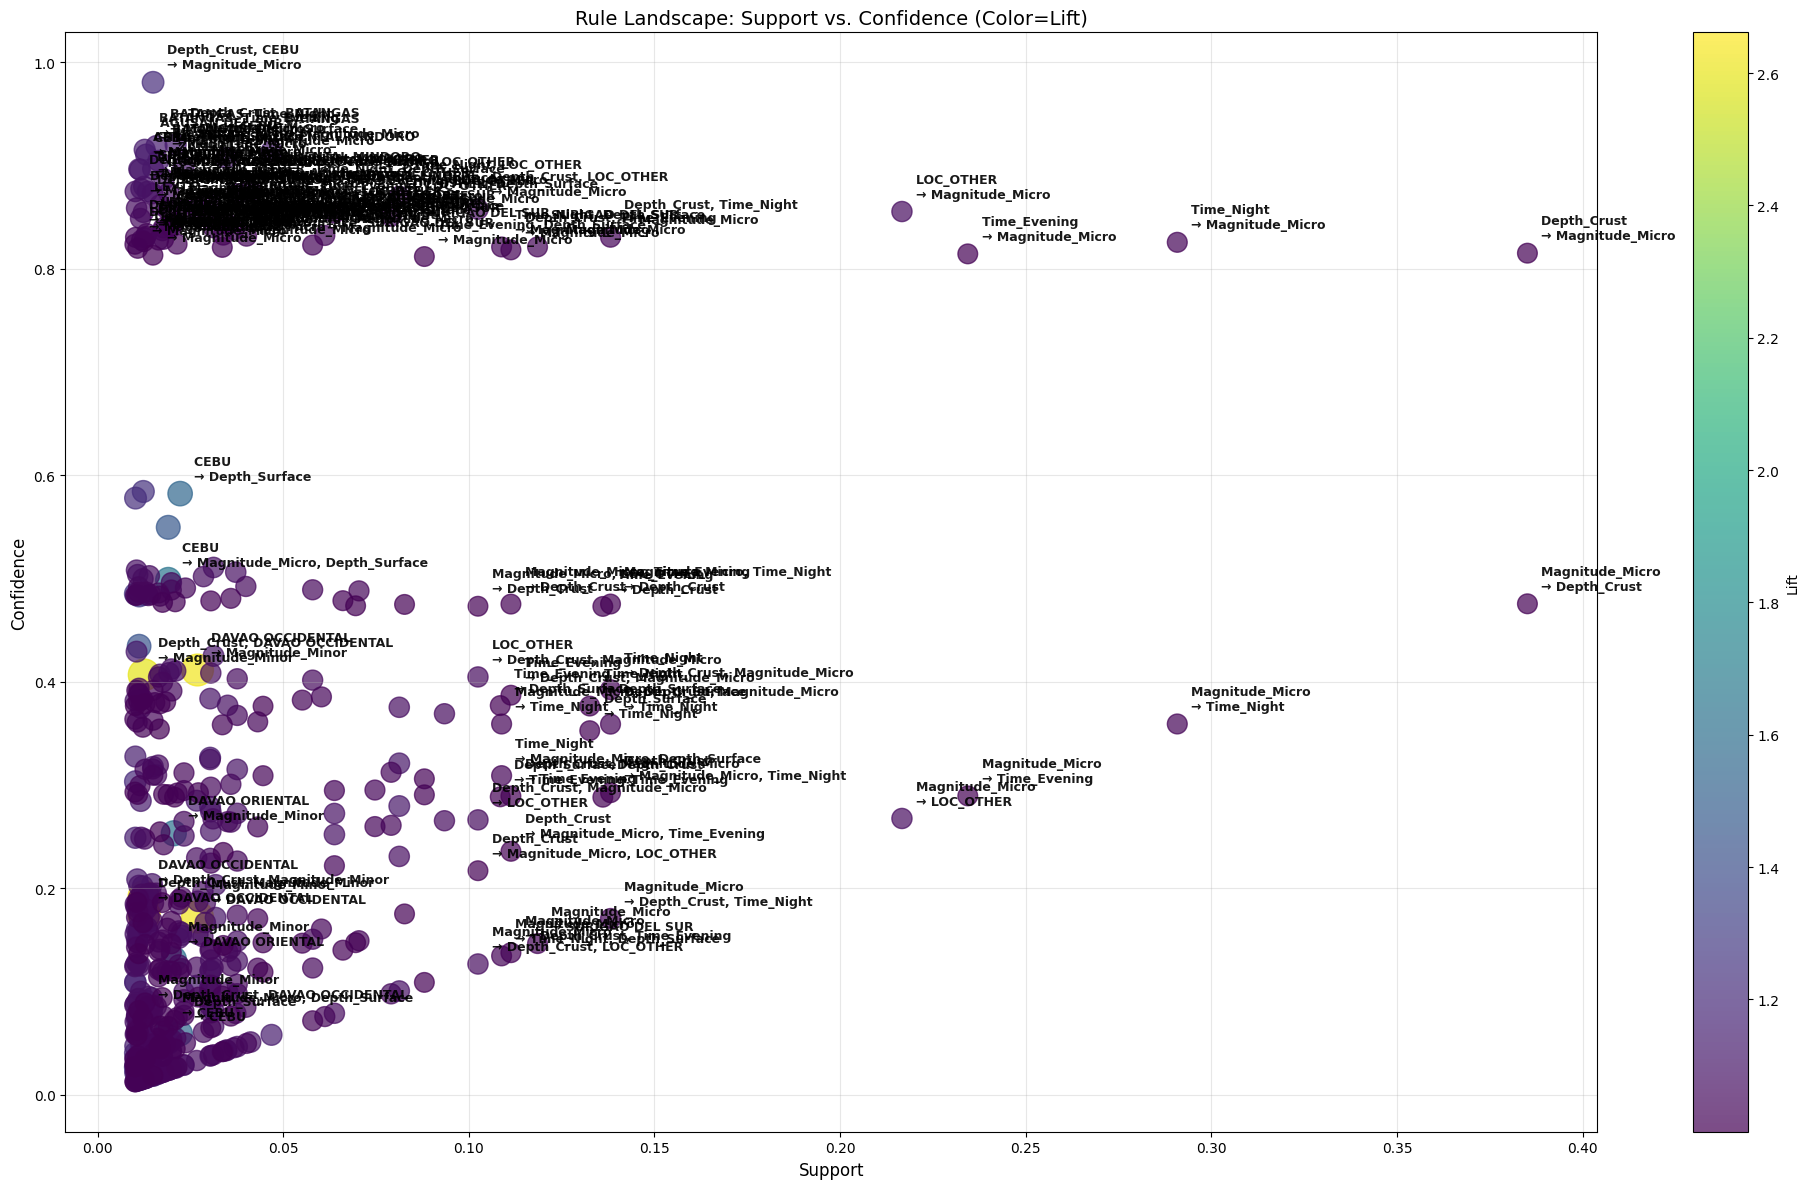

In [208]:
# Set the figure size (width=20 inches, height=12 inches)
fig, ax = plt.subplots(figsize=(20, 12))

scatter = ax.scatter(
    x=clean_rules["support"],
    y=clean_rules["confidence"],
    c=clean_rules["lift"],
    cmap="viridis",
    s=clean_rules["lift"] * 200,  # Increased multiplier for bigger dots
    alpha=0.7
)

for idx, row in clean_rules.iterrows():
    # Condition 1: High Confidence (The "Sure Things")
    is_high_conf = row['confidence'] > 0.6
    # Condition 2: High Lift (The "Strong Links")
    is_high_lift = row['lift'] > 1.5
    # Condition 3: High Support (The "Common Events")
    is_high_support = row['support'] > 0.1
    
    # Only label if it meets at least one condition
    if is_high_conf or is_high_lift or is_high_support:
        ax.annotate(
            f"{row['antecedents']} \n→ {row['consequents']}", # Added \n to stack text
            xy=(row['support'], row['confidence']),
            xytext=(10, 10),
            textcoords='offset points',
            fontsize=9,
            color='black',
            fontweight='bold',
            alpha=0.9
        )

ax.set_xlabel('Support', fontsize=12)
ax.set_ylabel('Confidence', fontsize=12)
ax.set_title("Rule Landscape: Support vs. Confidence (Color=Lift)", fontsize=14)
ax.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, label='Lift')

plt.tight_layout()
plt.show()